In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Qsharp
import qsharp

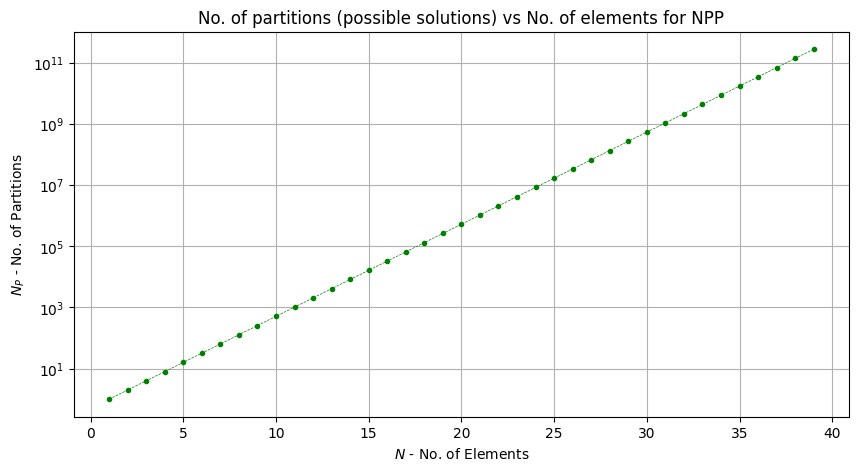

In [2]:
# Plotting number of partitions vs number of elements for NPP
input_size_plot = np.arange(1, 40, 1)
n_partitions = np.power(2,input_size_plot-1,dtype=np.int64)

plt.figure(figsize=(10, 5),dpi=100)
plt.plot(input_size_plot,n_partitions,c='g',ls='--',lw=0.5,marker='.')
plt.yscale('log')

plt.xlabel('$N$ - No. of Elements')
plt.ylabel('$N_P$ - No. of Partitions')

plt.grid()
plt.title("No. of partitions (possible solutions) vs No. of elements for NPP")

plt.show()

In [3]:
%%qsharp
// Q# snippet used to create and simulate the QAOA circuit.
namespace qaoa_note{

    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int{
        return n*i + j
    }
    // Cost Hamiltonian
    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit{

        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;

        // RZ Gates
        for qubit in 0..n_qubits-1{
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1{
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit])
        }
        // RZZ Gates
        for i in 0..n_qubits-1{
            for j in i+1..n_qubits-1{
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j])
            }
        }
    }

    // Mixer Hamiltonian
    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit{
        for qubit in qubits{
            Rx(2.0 * beta,qubit);
        }
    }

    // Function to create the QAOA circuit.
    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {

        use q = Qubit[NQubits];
        mutable integer_result = 0;

        // State Preparation |+>
        ApplyToEachA(H,q);

        for layer in 0..Layers-1{
            cost_unitary(q, gammas[layer], quadratics, linears);
            mixer_unitary(q, betas[layer]);
        }
        // Return the bitstring as an integer.
        return MeasureInteger(q);
    }
}

In [4]:
# Defining helper functions
def arr_to_str(a):
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1,2,3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

def generate_qsharp_string(n_qubits: int = 3,layers: int = 3) -> str:
    """Function to generate dummy input strings from no. of qubits and no. of layers"""

    # Preparing inputs for the Q# function.
    quadratics = np.array([1.1] * n_qubits**2)
    linears = np.array([1.2] * n_qubits)

    gammas = np.array([0.3] * layers)
    betas = np.array([0.4] * layers)

    input_str = f"{n_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears)}"
    qsharp_string = f"qaoa_note.circuit({input_str})"

    return qsharp_string

In [5]:
# Dictionary of all the resources we are tracking
resources = {"n_physical_qubits": ["physicalCounts","physicalQubits"],
            "circuit_runtime": ["physicalCounts","runtime"], # Runtime in nano-seconds
            "circuit_rqops": ["physicalCounts","rqops"], #Number of reliable quantum operations per second (rQOPS)
            "n_tstates": ["physicalCounts","breakdown","numTstates"],
            "required_logical_qubit_error": ["physicalCounts","breakdown","requiredLogicalQubitErrorRate"],
            "Code_distance": ["logicalQubit","codeDistance"],
            "tfactory_percentage": ["physicalCountsFormatted","physicalQubitsForTfactoriesPercentage"]}

In [6]:
test_params =[{
        "errorBudget": 0.05,
        "qubitParams": { "name": "qubit_gate_ns_e4" },
        "qecScheme": { "name": "surface_code" },
        "constraints": {"maxDuration":"3 s"}}]

physical_qubits = []
runtime = []
rqops = []
n_tstates = []
required_error = []
code_distance = []
tfactory_percentage = []

for input_size in input_size_plot:
    input_str = generate_qsharp_string(input_size,1)
    result = qsharp.estimate(input_str,params = test_params)

    physical_qubits.append(result[resources["n_physical_qubits"][0]]
                           [resources["n_physical_qubits"][1]])
    runtime.append(result[resources["circuit_runtime"][0]]
                   [resources["circuit_runtime"][1]])
    rqops.append(result[resources["circuit_rqops"][0]]
                 [resources["circuit_rqops"][1]])
    n_tstates.append(result[resources["n_tstates"][0]]
                     [resources["n_tstates"][1]]
                     [resources["n_tstates"][2]])
    required_error.append(result[resources["required_logical_qubit_error"][0]]
                          [resources["required_logical_qubit_error"][1]]
                          [resources["required_logical_qubit_error"][2]])
    code_distance.append(result[resources["Code_distance"][0]]
                         [resources["Code_distance"][1]])
    tfactory_percentage.append(result[resources["tfactory_percentage"][0]]
                         [resources["tfactory_percentage"][1]])

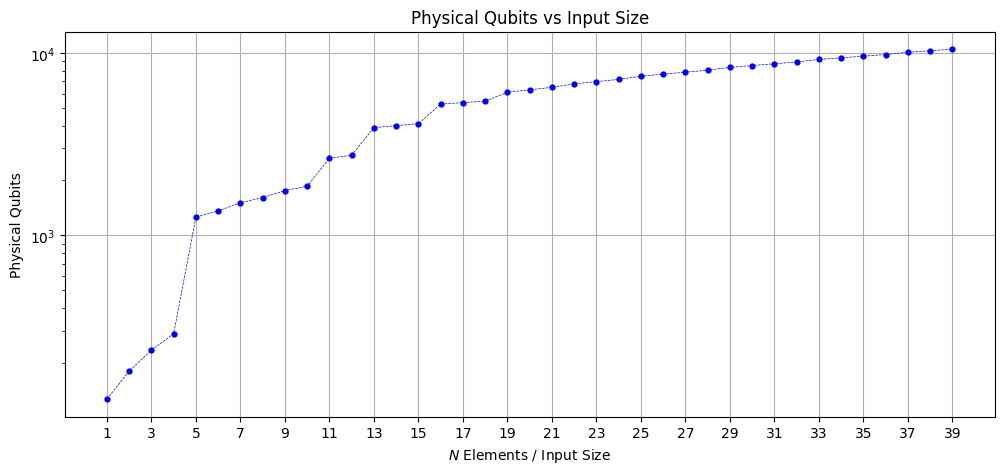

In [7]:
plt.figure(figsize=(12, 5),dpi=100)
plt.plot(input_size_plot,physical_qubits,c='blue',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')
plt.xticks(input_size_plot[::2])

plt.xlabel('$N$ Elements / Input Size')
plt.ylabel('Physical Qubits')

plt.grid()
plt.title("Physical Qubits vs Input Size")

plt.show()

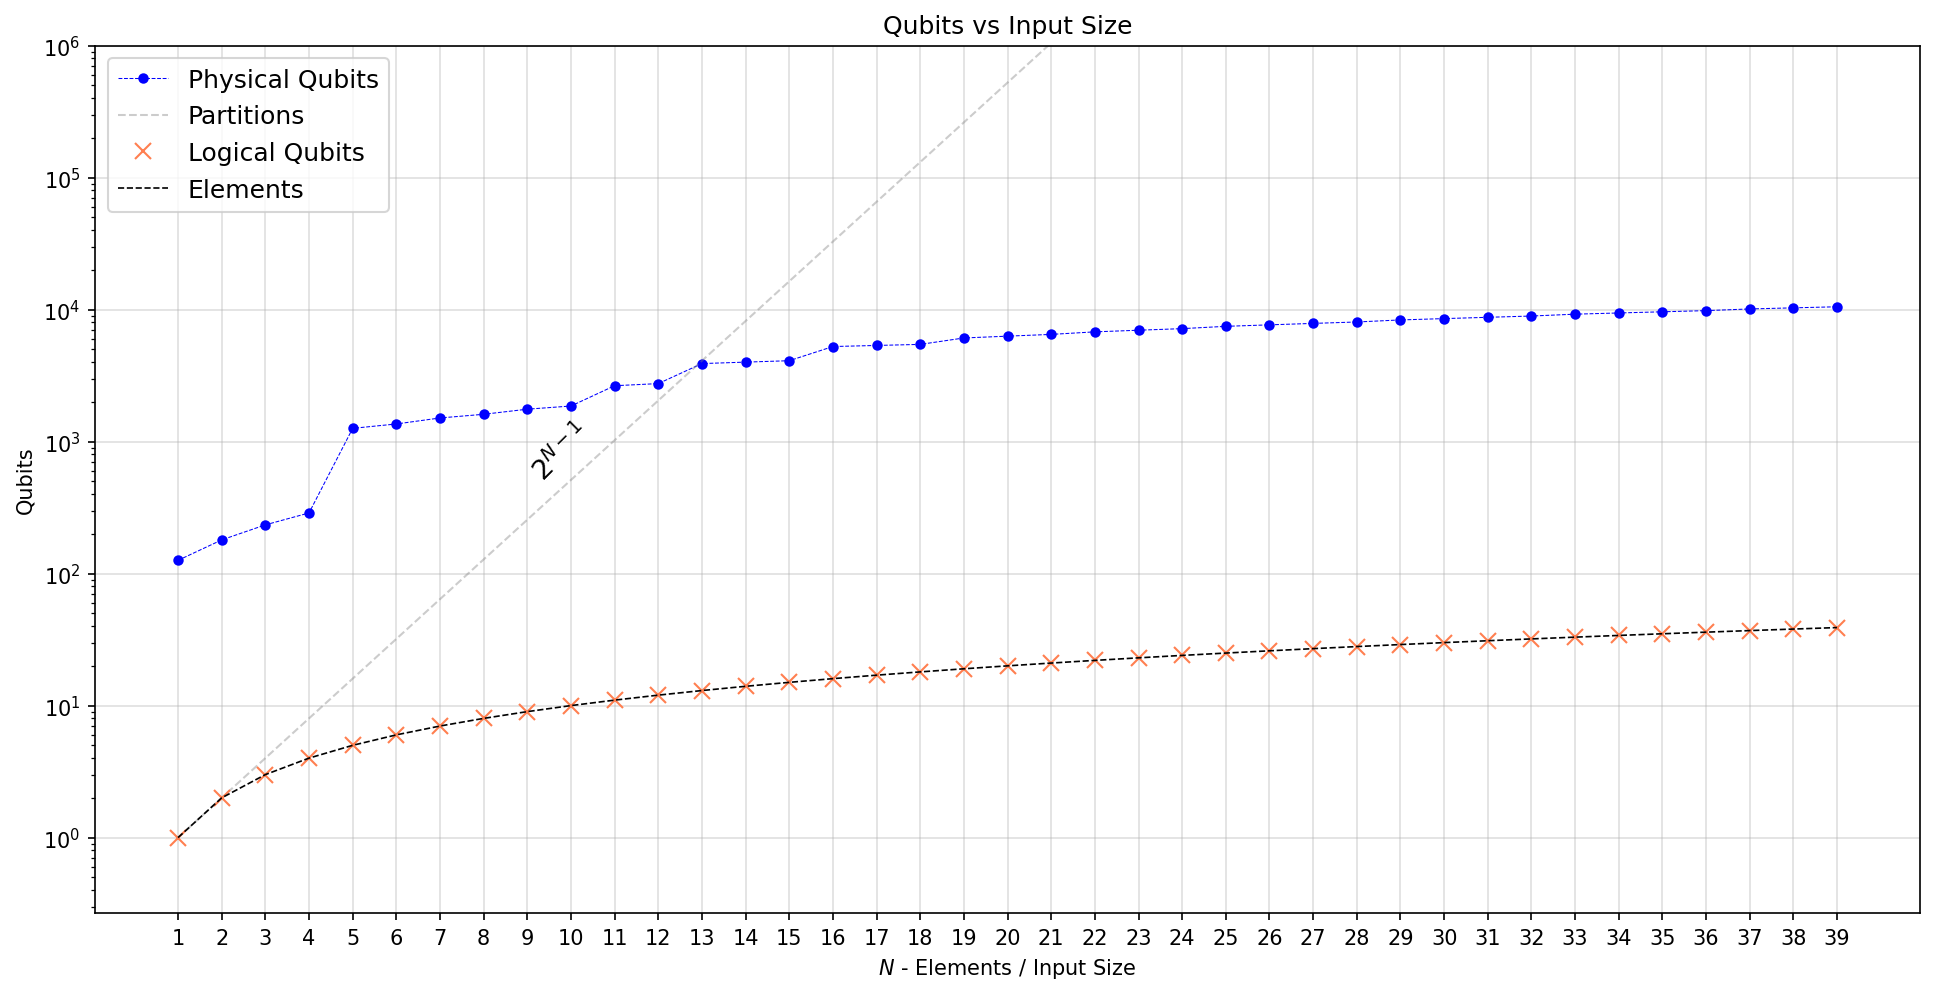

In [8]:
plt.figure(figsize=(13, 6.6),dpi=150)

# Physical Qubits
plt.plot(input_size_plot,physical_qubits,c='blue',ls='--',lw=0.5,marker='.',ms=8,label="Physical Qubits")

# Partitions
plt.plot(input_size_plot,n_partitions,c='gray',ls='--',lw=1,alpha=0.4,label="Partitions")

# Logical Qubits
plt.plot(input_size_plot,input_size_plot,c='coral',ls='',lw=1,marker='x',ms=8,label="Logical Qubits")

# Elements
plt.plot(input_size_plot,input_size_plot,c='black',ls='--',lw=0.8,label="Elements")

plt.yscale('log')
plt.xticks(input_size_plot)

plt.xlabel('$N$ - Elements / Input Size')
plt.ylabel('Qubits')

plt.ylim(top = 10e5)

plt.legend(loc="upper left",fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()

plt.text(x=9,y=n_partitions[9],s='$2^{N-1}$',fontsize=13,rotation=45)

plt.title("Qubits vs Input Size")

plt.show()

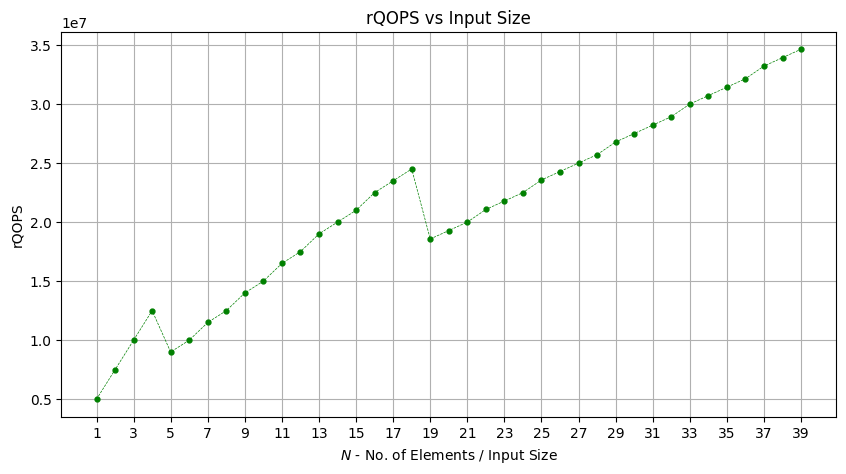

In [9]:
plt.figure(figsize=(10, 5),dpi=100)

plt.plot(input_size_plot,rqops,c='green',ls='--',lw=0.5,marker='.',ms=7)

# plt.yscale('log')

plt.xticks(input_size_plot[::2])
# plt.yticks([1e7,2e7,3e7,4e7])

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('rQOPS')

plt.grid()
plt.title("rQOPS vs Input Size")

plt.show()

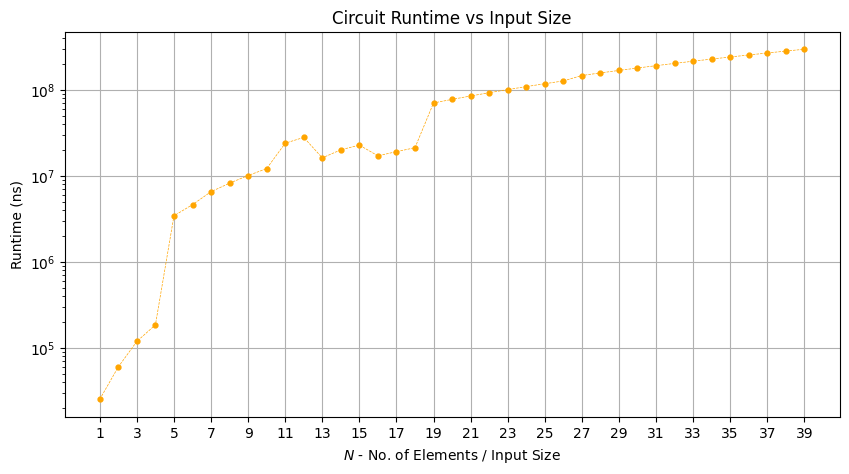

In [10]:
plt.figure(figsize=(10, 5),dpi=100)

plt.plot(input_size_plot,runtime,c='orange',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')

# plt.ylim(bottom = 1e3,top = 1e7)

plt.xticks(input_size_plot[::2])

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('Runtime (ns)')

plt.grid()
plt.title("Circuit Runtime vs Input Size")

plt.show()

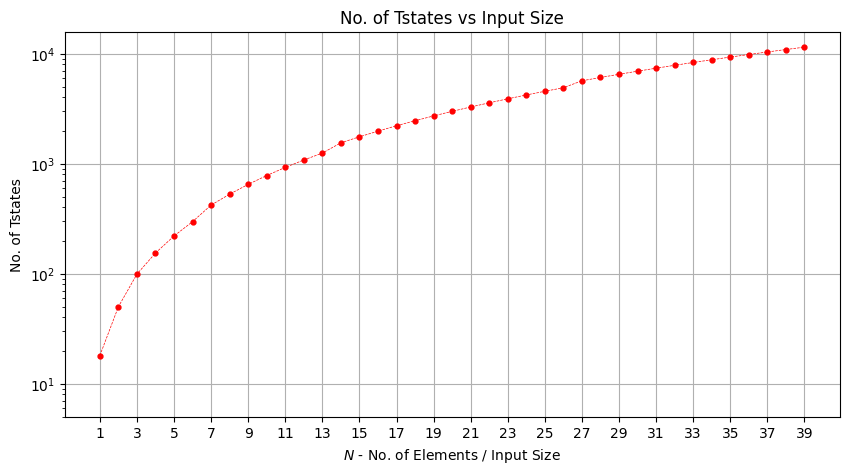

In [11]:
plt.figure(figsize=(10, 5),dpi=100)

plt.plot(input_size_plot,n_tstates,c='red',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('No. of Tstates')

plt.ylim(bottom = 5)

plt.xticks(input_size_plot[::2])

plt.grid()
plt.title("No. of Tstates vs Input Size")

plt.show()

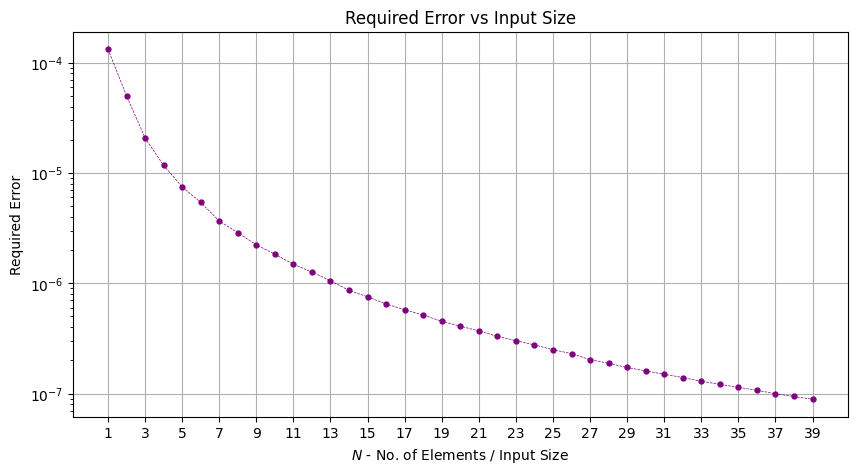

In [12]:
plt.figure(figsize=(10, 5),dpi=100)

plt.plot(input_size_plot,required_error,c='purple',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')

plt.xticks(input_size_plot[::2])

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('Required Error')

plt.grid()
plt.title('Required Error vs Input Size')

plt.show()

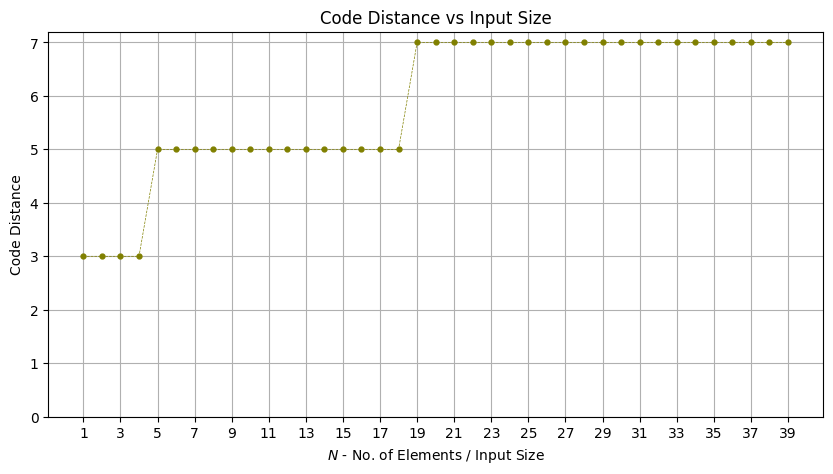

In [13]:
plt.figure(figsize=(10, 5),dpi=100)

plt.plot(input_size_plot,code_distance,c='olive',ls='--',lw=0.5,marker='.',ms=7)

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('Code Distance')

plt.yticks(np.arange(0, 8, step=1))
plt.xticks(input_size_plot[::2])

plt.grid()
plt.title("Code Distance vs Input Size")

plt.show()

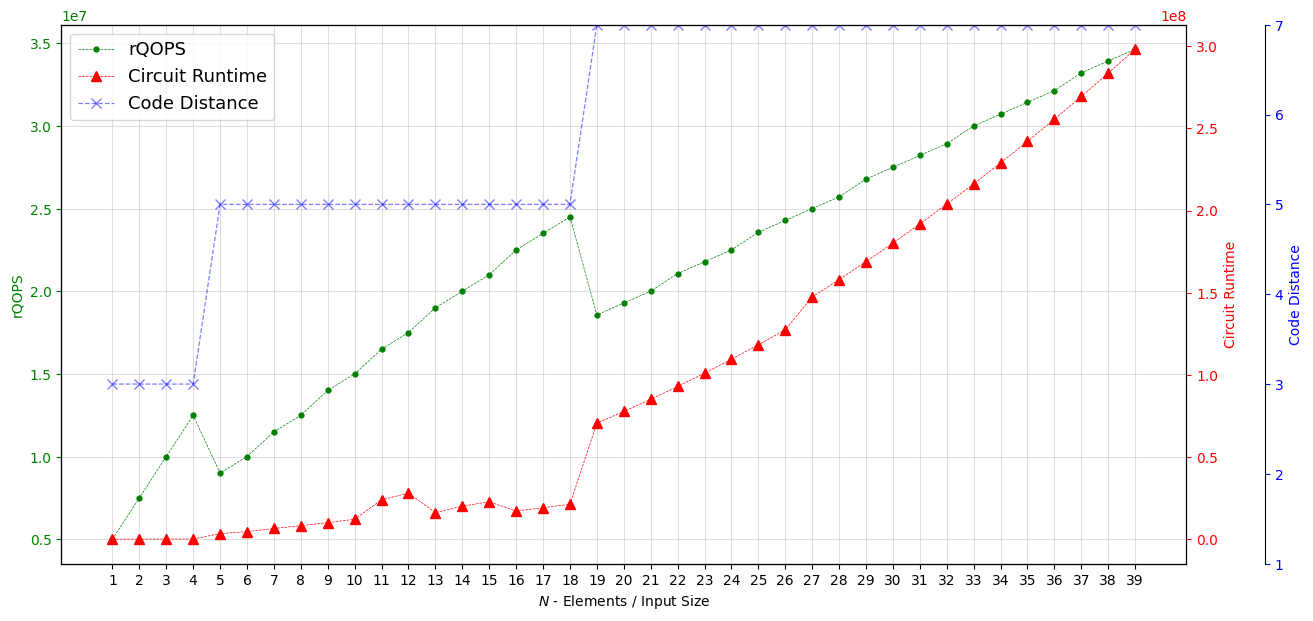

In [14]:
fig, ax = plt.subplots(figsize=(18, 7),dpi=100)
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.07))

p1, = ax.plot(input_size_plot,rqops,c='green',ls='--',lw=0.5,marker='.',ms=7,label="rQOPS")
p2, = twin1.plot(input_size_plot,runtime,c='red',ls='--',lw=0.5,marker='^',ms=7,label="Circuit Runtime")
p3, = twin2.plot(input_size_plot,code_distance,c='blue',ls='--',lw=0.9,marker='x',ms=7,label="Code Distance",alpha=.5)


ax.set(xlabel="$N$ - Elements / Input Size", ylabel="rQOPS")
twin1.set(ylabel="Circuit Runtime")
twin2.set(ylabel="Code Distance",ylim=(1, 7))

ax.set_xticks(input_size_plot)

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
twin2.tick_params(axis='y', colors=p3.get_color())

ax.legend(handles=[p1, p2, p3],fontsize=13)
ax.grid(alpha=0.4)

plt.show()

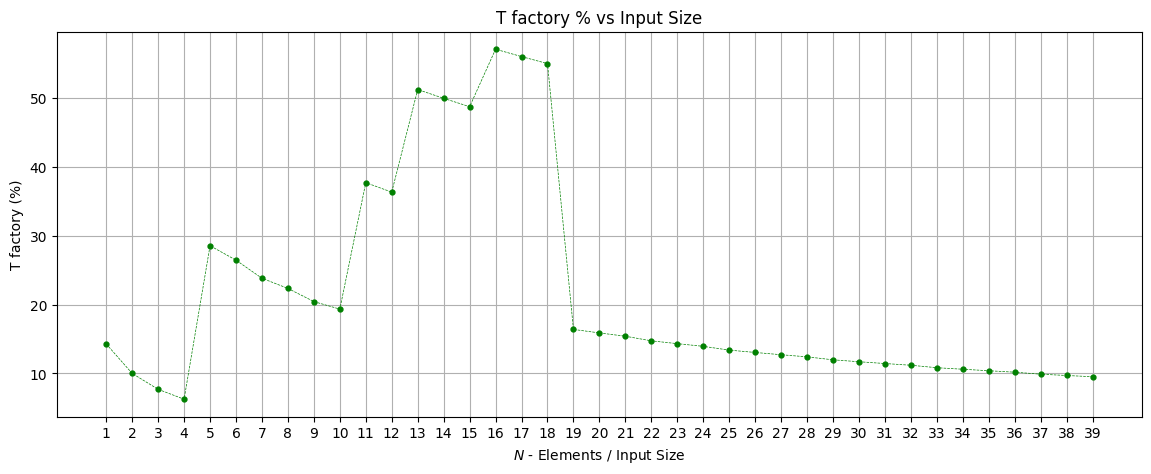

In [15]:
tfactory_percentage_arr = []
for i in tfactory_percentage:
    tfactory_percentage_arr.append(float(i[:-2]))

plt.figure(figsize=(14, 5),dpi=100)

plt.plot(input_size_plot,tfactory_percentage_arr,c='green',ls='--',lw=0.5,marker='.',ms=7)

plt.xlabel('$N$ - Elements / Input Size')
plt.ylabel('T factory (%)')

# plt.yticks(np.arange(0, 8, step=1))
plt.xticks(input_size_plot)

plt.grid()
plt.title("T factory % vs Input Size")

plt.show()

In [16]:
result.keys()

dict_keys(['status', 'jobParams', 'physicalCounts', 'physicalCountsFormatted', 'logicalQubit', 'tfactory', 'errorBudget', 'logicalCounts', 'reportData'])

In [17]:
result['physicalCounts']

{'physicalQubits': 10506,
 'runtime': 298116000,
 'rqops': 34642858,
 'breakdown': {'algorithmicLogicalQubits': 97,
  'algorithmicLogicalDepth': 1936,
  'logicalDepth': 106470,
  'numTstates': 11466,
  'clockFrequency': 357142.85714285716,
  'numTfactories': 1,
  'numTfactoryRuns': 11466,
  'physicalQubitsForTfactories': 1000,
  'physicalQubitsForAlgorithm': 9506,
  'requiredLogicalQubitErrorRate': 8.875067450512624e-08,
  'requiredLogicalTstateErrorRate': 1.4535728821443107e-06,
  'numTsPerRotation': 14,
  'cliffordErrorRate': 0.0001}}

In [18]:
result['tfactory']

{'physicalQubits': 1000,
 'runtime': 26000,
 'numTstates': 1,
 'numInputTstates': 15,
 'numRounds': 1,
 'numUnitsPerRound': [1],
 'unitNamePerRound': ['15-to-1 space efficient'],
 'codeDistancePerRound': [5],
 'physicalQubitsPerRound': [1000],
 'runtimePerRound': [26000],
 'logicalErrorRate': 2.1303500000000003e-07}

In [19]:
result['jobParams']

{'qecScheme': {'name': 'surface_code',
  'errorCorrectionThreshold': 0.01,
  'crossingPrefactor': 0.03,
  'logicalCycleTime': '(4 * twoQubitGateTime + 2 * oneQubitMeasurementTime) * codeDistance',
  'physicalQubitsPerLogicalQubit': '2 * codeDistance * codeDistance',
  'maxCodeDistance': 50},
 'errorBudget': 0.05,
 'qubitParams': {'instructionSet': 'GateBased',
  'name': 'qubit_gate_ns_e4',
  'oneQubitMeasurementTime': '100 ns',
  'oneQubitGateTime': '50 ns',
  'twoQubitGateTime': '50 ns',
  'tGateTime': '50 ns',
  'oneQubitMeasurementErrorRate': 0.0001,
  'oneQubitGateErrorRate': 0.0001,
  'twoQubitGateErrorRate': 0.0001,
  'tGateErrorRate': 0.0001,
  'idleErrorRate': 0.0001},
 'constraints': {'maxDuration': '3000000000 ns'},
 'estimateType': 'singlePoint'}

In [20]:
result['physicalCountsFormatted']

{'runtime': '298 millisecs',
 'rqops': '34.64M',
 'physicalQubits': '10.51k',
 'algorithmicLogicalQubits': '97',
 'algorithmicLogicalDepth': '1.94k',
 'logicalDepth': '106.47k',
 'numTstates': '11.47k',
 'numTfactories': '1',
 'numTfactoryRuns': '11.47k',
 'physicalQubitsForAlgorithm': '9.51k',
 'physicalQubitsForTfactories': '1.00k',
 'physicalQubitsForTfactoriesPercentage': '9.52 %',
 'requiredLogicalQubitErrorRate': '8.88e-8',
 'requiredLogicalTstateErrorRate': '1.45e-6',
 'physicalQubitsPerLogicalQubit': '98',
 'logicalCycleTime': '3 microsecs',
 'clockFrequency': '357.14k',
 'logicalErrorRate': '3.00e-10',
 'tfactoryPhysicalQubits': '1.00k',
 'tfactoryRuntime': '26 microsecs',
 'numInputTstates': '15',
 'numUnitsPerRound': '1',
 'unitNamePerRound': '15-to-1 space efficient',
 'codeDistancePerRound': '5',
 'physicalQubitsPerRound': '1.00k',
 'tfactoryRuntimePerRound': '26 microsecs',
 'tstateLogicalErrorRate': '2.13e-7',
 'logicalCountsNumQubits': '39',
 'logicalCountsTCount': '0',

In [ ]:
prop = []

for input_size in input_size_plot:
    input_str = generate_qsharp_string(input_size,1)
    res = qsharp.estimate(input_str,params = test_params)

    prop.append(int(res['physicalCounts']['breakdown']['physicalQubitsForTfactories']))

## Physical Qubits For Tfactories -> res['physicalCounts']['breakdown']['physicalQubitsForTfactories']

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(input_size_plot,prop,ls='',marker='.')
# plt.plot(input_size_plot,input_size_plot**2)
# alg = np.round(2 * input_size_plot + np.sqrt(8 * input_size_plot) + 1) + 1
# plt.plot(input_size_plot,alg)


plt.yscale('log')

# plt.yticks(range(0,100,3))
plt.xticks(input_size_plot)
plt.grid()
plt.title('Physical Qubits For Tfactories')
plt.show()

In [ ]:
prop[5] * 18,input_size_plot[5]

In [ ]:
prop[6] * 18,input_size_plot[6]

In [29]:
result

Runtime,298 millisecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (2,800 nanosecs) multiplied by the 1,936 logical cycles to run the algorithm. If however the duration of a single T factory (here: 26,000 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,34.64M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (97) (with a logical error rate of 8.88e-8) multiplied by the clock frequency (357,142.86), which is the number of logical cycles per second."
Physical qubits,10.51k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 9,506 physical qubits to implement the algorithm logic, and 1,000 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,97,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 39$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 97$ logical qubits."
Algorithmic depth,1.94k,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 39 single-qubit measurements, the 819 arbitrary single-qubit rotations, and the 0 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 77 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,106.47k,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 1,936. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,357.14k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 3 microsecs.
Number of T states,11.47k,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 0 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 819 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,1,"Number of T factories capable of producing the demanded 11,466 T states during the algorithm's runtime The total number of T factories 1 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{11,466 \cdot 26,000\;\text{ns}}{1 \cdot 298,116,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,11.47k,"Number of times all T factories are invoked In order to prepare the 11,466 T states, the 1 copies of the T factory are repeatedly invoked 11,466 times."
Physical algorithmic qubits,9.51k,"Number of physical qubits for the algorithm after layout The 9,506 are the product of the 97 logical qubits after layout and the 98 physical qubits that encode a single logical qubit."


In [24]:
result["physicalCountsFormatted"]["logicalCycleTime"]

'3 '

In [26]:
logic_time = []

for input_size in input_size_plot:
    input_str = generate_qsharp_string(input_size,1)
    res = qsharp.estimate(input_str,params = test_params)

    logic_time.append(result["physicalCountsFormatted"]["logicalCycleTime"])

In [28]:
len(logic_time)

39